In [214]:
import numpy as np
import pandas as pd
import math
import random

from croissance import process_curve
from croissance.estimation import fit_exponential
from croissance.figures import PDFWriter

import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import seaborn as sns
from matplotlib import cm
from scipy.signal import savgol_filter

# We offer two functionis: (1) a function to analyze a single growth curve and (2) a function to analyze all growth curves from a 96-well experiment at once

In [289]:
def growth_curve_analysis_single_curve(infile, # relative/full path of the growth curve
                                       my_col, # the column to analyze
                                       od_cutoff=None, # data that are smaller than od_cutoff will be removed
                                       blank=None, # row or column used as blank control wells
                                       verbose=True, # whether to print information in process
                                       my_xlim=None, # limit of x axis
                                       my_ylim=None, # limit of y axis
                                       max_phase_displayed=3 # maximum number of OD processed and displayed
                                       ):
    
    # read data
    if infile.split('.')[-1] == 'xlsx':
        df = pd.read_excel(infile, index_col=1).squeeze()
    elif infile.split('.')[-1] == 'csv':
        df = pd.read_csv(infile, index_col=1).squeeze()
    else:
        print('file format not recognized. support xlsx and csv only.')
        return
    
    # remove columns for temperature and cycle
    df=df.drop(columns=[df.columns[0],df.columns[1]])
    
    # convert time unit to hour
    df.index = df.index/3600
    df.index.names = ['Time (h)']
    
    if max_phase_displayed<0:
        print('value error: max_phase_displayed must be above zero')
        print('reset max_phase_displayed to 1')
    
    #print(df.head())

    # subtract baseline data (controls)
    if blank is not None:
        if blank.isalpha():
            # the blank is a row
            for index, col in enumerate(df.columns):
                # the variable "blank" is a letter, we need digits
                digits = ''.join(i for i in col if i.isdigit())
                #print(col, blank+digits)
                blank_index = df.columns.values.tolist().index(blank + digits)
                df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
    
        if blank.isdigit():
            # the blank is a column
            for index, col in  enumerate(df.columns):
                # the variable "blank" is digital, we need a letter
                letter = ''.join(i for i in col if i.isalpha())
                #print(col, letter+blank)
                blank_index = df.columns.values.tolist().index(letter + blank)
                df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
            
    # to plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    # colors
    colors_to_display = []
    for i in range(100):
        colors_to_display.append("#{:06x}".format(random.randint(0, 0xFFFFFF)))

    for index, col in enumerate(df.columns): 
        if col != my_col:
            continue
        
        #df[col] = savgol_filter(df[col].values, 11, 3)
        try:
            # cutoff OD
            if od_cutoff is None:
                curve = df[col]
            else:
                curve = df.loc[df[col] >= od_cutoff, col]
                
            if curve.empty: # curve is empty
                print(col, ': data is empty.')
                
                # control plot
                ax.set_xticklabels([])
                ax.set_yticklabels([]) 
                ax.minorticks_off()
                continue
            else:
                # extract growth parameters using croissance
                results = process_curve(curve,constrain_n0=True, n0=0.)
        except:
            # no cutoff if any error pops up when runing croissance
            print('Warning: croissnace fails to process thresholded curve. use curve without cutoff.')
            curve = df[col]
            if curve.empty: # curve is empty
                print(col, ': data is empty.')

                # control plot
                ax.set_xticklabels([])
                ax.set_yticklabels([]) 
                ax.minorticks_off()
            
                continue
            else:
                # extract growth parameters using croissance
                results = process_curve(curve,constrain_n0=True, n0=0.)
            
        # the phase is outputed in order of its score of confidence by croissance
        # we need to find its order in time
        start_time = []
        for phase in results.growth_phases:
            start_time.append(phase.start)
        if start_time:
            pi_order_in_time = np.argsort(start_time)
    
        #---------------------------------------------------
        # get growth rate and lag time for each growth phase
        #---------------------------------------------------
        growth_rate=[]
        lag_time=[]
        growth_rate_star=float('nan')
        lag_time_star=float('nan')
        for pi in range(len(results.growth_phases)):
            
            if pi+1 > max_phase_displayed:
                break
            else:
                phase = results.growth_phases[pi_order_in_time[pi]]
                phase_series = results.series[phase.start:phase.end]
                
            def exp_growth_w_offset(x, y0, y1, mu):
                return y0 + y1 * np.exp(mu * x)
            
            def exp_growth_wo_offset(x, y1, mu):
                return y1 * np.exp(mu * x)
                        
            # fit with w/ offset model
            w_offset = True
            init_vals = [0, #phase_series.values[0], 
                         1/ np.exp(phase.intercept * phase.slope),
                        phase.slope]  # for [y0, y1, mu]
            best_vals, covar = curve_fit(exp_growth_w_offset, phase_series.index, phase_series.values, p0=init_vals, 
                                         bounds = ([0,0,0], [math.inf,math.inf,math.inf]), maxfev=10000)
            
            # growth rate
            growth_rate.append(best_vals[2])
            
            # tentative lag time
            tentative_lag_time = np.log(best_vals[0]/best_vals[1])/best_vals[2]
            #print([phase.start,tentative_lag_time,phase.end])
            if tentative_lag_time >= phase.start and tentative_lag_time <= phase.end:
                lag_time.append(tentative_lag_time)
                if lag_time_star != lag_time_star: # is a nan?
                    growth_rate_star = best_vals[2]
                    lag_time_star = tentative_lag_time
            elif tentative_lag_time < phase.start:
                # growth curve may start with exponential phase (for some reason, lag phase is missing)
                # in this case, we do our best guess and set the start of exponential phase equal to the 
                # start of the growth phase
                lag_time.append(phase.start)
                if lag_time_star != lag_time_star: # is a nan?
                    growth_rate_star = best_vals[2]
                    lag_time_star = phase.start
            else:
                # this indicates that exponential phase has not been reached
                # we also provide our best estimate
                lag_time.append(tentative_lag_time)

            # plot local growth phases identified by croissance
            ax.plot(phase_series.index,
                    phase_series.values,
                    marker=None,
                    linewidth=10,
                    color=colors_to_display[pi],
                    solid_capstyle='butt',
                    alpha=0.5)
            
            # plot model fitting
            if w_offset:
                ax.plot(results.series.index,
                        exp_growth_w_offset(results.series.index, best_vals[0], best_vals[1], best_vals[2]), 
                        color=colors_to_display[pi],
                        linewidth=2,
                        linestyle='solid')
            else:
                ax.plot(results.series.index,
                        exp_growth_wo_offset(results.series.index, best_vals[0], best_vals[1]), 
                        color=colors_to_display[pi],
                        linewidth=2,
                        linestyle='solid')
                        
        # print to screen
        if verbose:
            if len(results.growth_phases)==0:
                print(col, ': no growth phase is found.')
            else:
                print('%s : %d growth phases found, rate=(' % (col, len(results.growth_phases)), end='')
                maxp = np.min([len(results.growth_phases),max_phase_displayed])
                for pi in range(maxp):
                    if pi == maxp-1:
                        print('%1.2f), lag=(' % growth_rate[pi], end='')
                    else:
                        print('%1.2f,' % growth_rate[pi], end='')
                for pi in range(maxp):
                    if pi == maxp-1:
                        print('%2.2f), ' % lag_time[pi], end='')
                    else:
                        print('%2.2f,' % lag_time[pi], end='')
                if lag_time_star != lag_time_star:
                    print('no exponential phase is found.')
                else:
                    print('rate* = %1.2f, lag* = %2.2f' % (growth_rate_star, lag_time_star))
               
        # plot original data
        ax.plot(results.series.index,
                                        results.series.values,
                                        color='black',
                                        marker='.',
                                        markersize=5,
                                        linestyle='None')
        # plot outliers
        ax.plot(results.outliers.index,
                                        results.outliers.values,
                                        color='red',
                                        marker='.',
                                        markersize=5,
                                        linestyle='None')
        
        # set xlim
        if my_xlim is not None:
            ax.set_xlim(my_xlim)
            ax.plot(my_xlim,[od_cutoff,od_cutoff],color='k',linestyle='dashed')
        else:
            ax.set_xlim([0,np.max(df.index.values)])
            ax.plot([0,np.max(df.index.values)],[od_cutoff,od_cutoff],color='k',linestyle='dashed')
        
        # set ylim
        if my_ylim is not None:
            ax.set_ylim(my_ylim)
        else:
            if curve.max()>0:
                if curve.min()>0:
                    ax.set_ylim([curve.min()/2, curve.max()*2])
                else:
                    ax.set_ylim([0.005, curve.max()*2])
        
        ax.set_yscale('log')
        
    plt.show()
    plt.tight_layout()
    
    return

In [290]:
def growth_curve_analysis_all_at_once(infile, # relative/full path of the growth curve
                                      od_cutoff=None, # data that are smaller than od_cutoff will be removed
                                      blank=None, # row or column used as blank control wells
                                      verbose=True, # whether to print information in process
                                      my_xlim=None, # limit of x axis
                                      my_ylim=None, # limit of y axis
                                      od_output_time=0, # time at which OD values are outputed
                                      max_phase_displayed=3 # maximum number of OD processed and displayed
                                     ):
    
    # read data
    if infile.split('.')[-1] == 'xlsx':
        df = pd.read_excel(infile, index_col=1).squeeze()
    elif infile.split('.')[-1] == 'csv':
        df = pd.read_csv(infile, index_col=1).squeeze()
    else:
        print('file format not recognized. support xlsx and csv only.')
        return
    
    # remove columns for temperature and cycle
    df=df.drop(columns=[df.columns[0],df.columns[1]])
    
    # convert time unit to hour
    df.index = df.index/3600
    df.index.names = ['Time (h)']
    
    if od_output_time<np.min(df.index.values) or od_output_time>np.max(df.index.values):
        print('value error for od_output_time: must be a value between %2.2f and %2.2f' 
              % (np.min(df.index.values), np.min(df.index.values)))
        print('reset od_output_time to the final time')
        od_output_time = np.min(df.index.values)
        
    if max_phase_displayed<0:
        print('value error: max_phase_displayed must be above zero')
        print('reset max_phase_displayed to 1')
    
    #print(df.head())

    # subtract baseline data (controls)
    if blank is not None:
        if blank.isalpha():
            # the blank is a row
            for index, col in enumerate(df.columns):
                # the variable "blank" is a letter, we need digits
                digits = ''.join(i for i in col if i.isdigit())
                #print(col, blank+digits)
                blank_index = df.columns.values.tolist().index(blank + digits)
                df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
    
        if blank.isdigit():
            # the blank is a column
            for index, col in  enumerate(df.columns):
                # the variable "blank" is digital, we need a letter
                letter = ''.join(i for i in col if i.isalpha())
                #print(col, letter+blank)
                blank_index = df.columns.values.tolist().index(letter + blank)
                df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
            
    # to plot
    fig, axes = plt.subplots(nrows=8, ncols=12, figsize=(16, 10))

    # colors
    colors_to_display = []
    for i in range(100):
        colors_to_display.append("#{:06x}".format(random.randint(0, 0xFFFFFF)))

    saved_data = []
    for index, col in enumerate(df.columns): 

        # row and column index
        row_index = int(index % 8)
        col_index = int(np.floor(index/8))   
        
        #df[col] = savgol_filter(df[col].values, 11, 3)
        try:
            # cutoff OD
            if od_cutoff is None:
                curve = df[col]
            else:
                curve = df.loc[df[col] >= od_cutoff, col]
                
            if curve.empty: # curve is empty
                print(col, ': data is empty.')
                
                # write output
                mydict = {}
                mydict.update({'init_od'  : float('nan'),
                               'od_output_time': float('nan'),
                               'max_od'   : float('nan'),
                               'final_od' : float('nan'),
                               'growth_rate_star' : float('nan'),
                               'lag_time_star' : float('nan')})
                for k in range(max_phase_displayed):
                    mydict.update({'start_time'+str(k+1)   : float('nan'),
                                   'end_time'  +str(k+1)   : float('nan'),
                                   'growth_rate'+str(k+1)  : float('nan'),
                                   'lag_time'  +str(k+1)   : float('nan')})
                saved_data.append(mydict)
                
                # control plot
                axes[row_index, col_index].set_xticklabels([])
                axes[row_index, col_index].set_yticklabels([]) 
                axes[row_index, col_index].minorticks_off()
                continue
            else:
                # extract growth parameters using croissance
                results = process_curve(curve,constrain_n0=True, n0=0.)
            
        except:
            # no cutoff if any error pops up when runing croissance
            #print('Warning: croissnace fails to process thresholded curve. use curve without cutoff.')
            
            curve = df[col]
            if curve.empty: # curve is empty
                print(col, ': data is empty.')
                
                # write output
                mydict = {}
                mydict.update({'init_od'  : float('nan'),
                               'od_output_time': float('nan'),
                               'max_od'   : float('nan'),
                               'final_od' : float('nan'),
                               'growth_rate_star' : float('nan'),
                               'lag_time_star' : float('nan')})
                for k in range(max_phase_displayed):
                    mydict.update({'start_time'+str(k+1)   : float('nan'),
                                   'end_time'  +str(k+1)   : float('nan'),
                                   'growth_rate'+str(k+1)  : float('nan'),
                                   'lag_time'  +str(k+1)   : float('nan')})
                saved_data.append(mydict)
            
                # control plot
                axes[row_index, col_index].set_xticklabels([])
                axes[row_index, col_index].set_yticklabels([]) 
                axes[row_index, col_index].minorticks_off()
            
                continue
            else:
                # extract growth parameters using croissance
                results = process_curve(curve,constrain_n0=True, n0=0.)
            
        # the phase is outputed in order of its score of confidence by croissance
        # we need to find its order in time
        start_time = []
        for phase in results.growth_phases:
            start_time.append(phase.start)
        if start_time:
            pi_order_in_time = np.argsort(start_time)
    
        #---------------------------------------------------
        # get growth rate and lag time for each growth phase
        #---------------------------------------------------
        
        # write output
        mydict = {}
        growth_rate = []
        lag_time  = []
        growth_rate_star = float('nan')
        lag_time_star = float('nan')
        interp_od = interp1d(curve.index, curve.values, fill_value="extrapolate")
        mydict.update({'init_od'  : curve.values[0],
                       'od_output_time': interp_od(od_output_time),
                       'max_od'   : np.max(curve.values),
                       'final_od' : curve.values[-1]})
        
        for pi in range(len(results.growth_phases)):
            
            if pi+1 > max_phase_displayed:
                break
            else:
                phase = results.growth_phases[pi_order_in_time[pi]]
                phase_series = results.series[phase.start:phase.end]
                
            def exp_growth_w_offset(x, y0, y1, mu):
                return y0 + y1 * np.exp(mu * x)
            
            def exp_growth_wo_offset(x, y1, mu):
                return y1 * np.exp(mu * x)
                        
            # fit with w/ offset model
            w_offset = True
            init_vals = [0,#phase_series.values[0], 
                         1/ np.exp(phase.intercept * phase.slope),
                        phase.slope]  # for [y0, y1, mu]
            best_vals, covar = curve_fit(exp_growth_w_offset, phase_series.index, phase_series.values, p0=init_vals, 
                                         bounds = ([0,0,0], [math.inf,math.inf,math.inf]), maxfev=10000)      
            
            # growth rate
            growth_rate.append(best_vals[2])
            
            # tentative lag time
            tentative_lag_time = np.log(best_vals[0]/best_vals[1])/best_vals[2]
            if tentative_lag_time >= phase.start and tentative_lag_time <= phase.end:
                lag_time.append(tentative_lag_time)
                if lag_time_star != lag_time_star: # is a nan?
                    growth_rate_star = best_vals[2]
                    lag_time_star = tentative_lag_time
            elif tentative_lag_time < phase.start:
                # growth curve may start with exponential phase (for some reason, lag phase is missing)
                # in this case, we do our best guess and set the start of exponential phase equal to the 
                # start of the growth phase
                lag_time.append(phase.start)
                if lag_time_star != lag_time_star: # is a nan?
                    growth_rate_star = best_vals[2]
                    lag_time_star = phase.start
            else:
                # this indicates that exponential phase has not been reached
                # we also provide our best estimate
                lag_time.append(tentative_lag_time)
          
            # write output
            mydict.update({'start_time'+str(pi+1)   : phase.start,
                           'end_time'  +str(pi+1)   : phase.end,
                           'growth_rate' +str(pi+1) : growth_rate[-1],
                           'lag_time'  +str(pi+1)   : lag_time[-1]})
            
            # plot local growth phases identified by croissance
            axes[row_index, col_index].plot(phase_series.index,
                                            phase_series.values,
                                            marker=None,
                                            linewidth=5,
                                            color=colors_to_display[pi],
                                            solid_capstyle='butt',
                                            alpha=0.5)
            # plot model fitting
            if w_offset:
                axes[row_index, col_index].plot(results.series.index,
                                                exp_growth_w_offset(results.series.index, best_vals[0], best_vals[1], best_vals[2]), 
                                                color=colors_to_display[pi],
                                                linewidth=1.5,
                                                linestyle='solid')
            else:
                axes[row_index, col_index].plot(results.series.index,
                                                exp_growth_wo_offset(results.series.index, best_vals[0], best_vals[1]), 
                                                color=colors_to_display[pi],
                                                linewidth=1.5,
                                                linestyle='solid')
                
        mydict.update({'growth_rate_star': growth_rate_star,
                       'lag_time_star'   : lag_time_star})
        saved_data.append(mydict)
        
        # print to screen
        if verbose:
            if len(results.growth_phases)==0:
                print(col, ': no growth phase is found.')
            else:
                print('%s : %d growth phases found, rate=(' % (col, len(results.growth_phases)), end='')
                maxp = np.min([len(results.growth_phases),max_phase_displayed])
                for pi in range(maxp):
                    if pi == np.min([len(results.growth_phases),max_phase_displayed])-1:
                        print('%1.2f), lag=(' % growth_rate[pi], end='')
                    else:
                        print('%1.2f,' % growth_rate[pi], end='')
                for pi in range(maxp):
                    if pi == np.min([len(results.growth_phases),max_phase_displayed])-1:
                        print('%2.2f), ' % lag_time[pi], end='')
                    else:
                        print('%2.2f,' % lag_time[pi], end='')
                if lag_time_star != lag_time_star:
                    print('no exponential phase is found.')
                else:
                    print('rate* = %1.2f, lag* = %2.2f' % (growth_rate_star, lag_time_star))

        # plot original data
        axes[row_index, col_index].plot(results.series.index,
                                        results.series.values,
                                        color='black',
                                        marker='.',
                                        markersize=1,
                                        linestyle='None')
        # plot outliers
        axes[row_index, col_index].plot(results.outliers.index,
                                        results.outliers.values,
                                        color='red',
                                        marker='.',
                                        markersize=1,
                                        linestyle='None')
        
        # set xlim
        if my_xlim is not None:
            axes[row_index, col_index].set_xlim(my_xlim)
            axes[row_index, col_index].plot(my_xlim,[od_cutoff,od_cutoff],color='k',linestyle='dashed')
        else:
            axes[row_index, col_index].set_xlim([0,np.max(df.index.values)])
            axes[row_index, col_index].plot([0,np.max(df.index.values)],[od_cutoff,od_cutoff],color='k',linestyle='dashed')
        
        # set ylim
        if my_ylim is not None:
            axes[row_index, col_index].set_ylim(my_ylim)
        else:
            if curve.max()>0:
                if curve.min()>0:
                    axes[row_index, col_index].set_ylim([curve.min()/2, curve.max()*2])
                else:
                    axes[row_index, col_index].set_ylim([0.005, curve.max()*2])
        
        axes[row_index, col_index].set_yscale('log')
        axes[row_index, col_index].set_xticklabels([])
        axes[row_index, col_index].set_yticklabels([]) 
        axes[row_index, col_index].minorticks_off()
        
    # output
    output = pd.DataFrame(saved_data)
    output.index = df.columns
    
    plt.show()
    plt.tight_layout()
    
    return output

# Run test 1: growth curve analysis of PA14 and NalD mutant in glycerol + casamino acids

A1 : 2 growth phases found, rate=(1.03,0.01), lag=(2.88,9.65), rate* = 1.03, lag* = 2.88
B1 : 1 growth phases found, rate=(1.12), lag=(1.35), rate* = 1.12, lag* = 1.35
C1 : 2 growth phases found, rate=(1.04,1.07), lag=(1.92,16.73), rate* = 1.04, lag* = 1.92
D1 : 1 growth phases found, rate=(1.12), lag=(1.52), rate* = 1.12, lag* = 1.52
E1 : 1 growth phases found, rate=(1.43), lag=(1.52), rate* = 1.43, lag* = 1.52
F1 : 2 growth phases found, rate=(1.90,0.39), lag=(0.85,17.11), rate* = 1.90, lag* = 0.85
G1 : no growth phase is found.
H1 : data is empty.
A2 : 1 growth phases found, rate=(1.11), lag=(1.35), rate* = 1.11, lag* = 1.35
B2 : 2 growth phases found, rate=(0.99,0.03), lag=(1.52,11.35), rate* = 0.99, lag* = 1.52
C2 : 2 growth phases found, rate=(1.01,0.03), lag=(1.52,10.67), rate* = 1.01, lag* = 1.52
D2 : 2 growth phases found, rate=(0.96,0.82), lag=(1.52,18.88), rate* = 0.96, lag* = 1.52
E2 : 1 growth phases found, rate=(1.39), lag=(1.69), rate* = 1.39, lag* = 1.69
F2 : 2 growth p

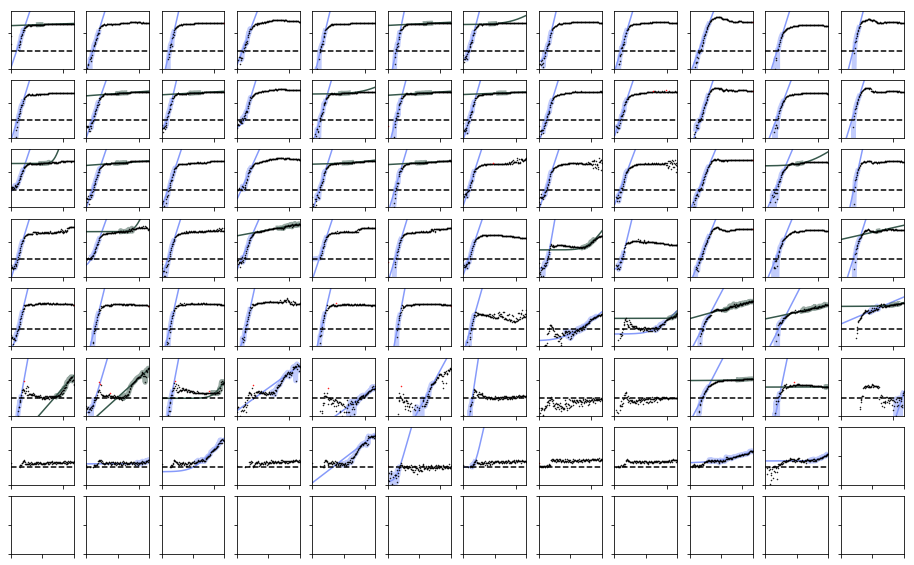

<Figure size 432x288 with 0 Axes>

In [251]:
output_test1_181219 = growth_curve_analysis_all_at_once(
    infile='181219_aztMIC.xlsx', 
    od_cutoff=0.01, 
    blank='H', 
    verbose=True,
    my_xlim=[0,24],
    my_ylim=[0.001,2],
    od_output_time=12)

In [252]:
output_test1_181219.head()

,end_time1,end_time2,end_time3,final_od,growth_rate1,growth_rate2,growth_rate3,growth_rate_star,init_od,lag_time1,lag_time2,lag_time3,lag_time_star,max_od,od_output_time,start_time1,start_time2,start_time3
A1,5.08,12.53,NaN,0.35,1.03,0.01,NaN,1.03,7.09e-02,2.88,9.65,NaN,2.88,0.37,0.32328547072154407,2.88,9.65,NaN
B1,4.91,NaN,NaN,0.35,1.12,NaN,NaN,1.12,-2.30e-03,1.35,NaN,NaN,1.35,0.38,0.30466336179329107,1.35,NaN,NaN
C1,4.91,14.73,NaN,0.42,1.04,1.07,NaN,1.04,1.21e-02,1.92,16.73,NaN,1.92,0.43,0.3171889451882384,1.35,10.67,NaN
D1,4.74,NaN,NaN,0.68,1.12,NaN,NaN,1.12,3.10e-03,1.52,NaN,NaN,1.52,0.69,0.3431555384066043,1.52,NaN,NaN
E1,4.57,NaN,NaN,0.21,1.43,NaN,NaN,1.43,4.30e-03,1.52,NaN,NaN,1.52,0.28,0.2668900605012465,1.52,NaN,NaN


0.15 <= growth rate (1/h) <= 2.26
0.00 <= lag time (h) <= 22.96


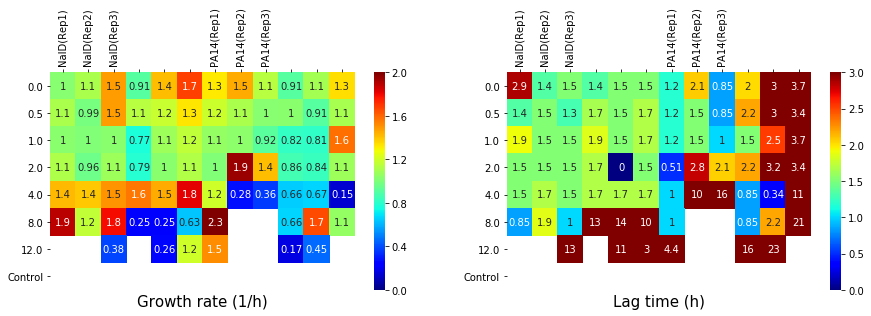

In [254]:
# visualize growth rate and lag time
print('%2.2f <= growth rate (1/h) <= %2.2f' %(np.nanmin(output_test1_181219['growth_rate_star'].values), 
                                              np.nanmax(output_test1_181219['growth_rate_star'].values)))
print('%2.2f <= lag time (h) <= %2.2f'  %(np.nanmin(output_test1_181219['lag_time_star'].values), 
                                          np.nanmax(output_test1_181219['lag_time_star'].values)))

fig,(ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios':[1,1]},figsize=(15,4))

# growth rate
to_plot1 = pd.DataFrame(output_test1_181219['growth_rate_star'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='jet', vmin=0, vmax=2.0, ax=ax1, cbar=True)
ax1.set_xlabel('Growth rate (1/h)', fontsize=15)

# lag time
to_plot2 = pd.DataFrame(output_test1_181219['lag_time_star'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='jet', vmin=0, vmax=3, ax=ax2, cbar=True)
ax2.set_xlabel('Lag time (h)', fontsize=15)

for ax in [g1,g2]:
    ax.set_yticklabels(['0.0','0.5','1.0','2.0','4.0','8.0','12.0','Control'], rotation=0)
    ax.set_xticklabels(['NalD(Rep1)','NalD(Rep2)','NalD(Rep3)','','','','PA14(Rep1)','PA14(Rep2)','PA14(Rep3)','','',''], rotation=90)
    ax.xaxis.tick_top()

plt.show()

## Calculate averaged growth rate and OD at 12h

A1 : 2 growth phases found, rate=(1.61,0.04), lag=(2.54,9.15), rate* = 1.61, lag* = 2.54
B1 : 2 growth phases found, rate=(1.45,0.28), lag=(1.63,16.37), rate* = 1.45, lag* = 1.63
C1 : 1 growth phases found, rate=(1.58), lag=(2.47), rate* = 1.58, lag* = 2.47
D1 : 1 growth phases found, rate=(1.01), lag=(1.52), rate* = 1.01, lag* = 1.52
E1 : 1 growth phases found, rate=(1.45), lag=(1.52), rate* = 1.45, lag* = 1.52
F1 : 2 growth phases found, rate=(2.23,0.59), lag=(0.68,14.15), rate* = 2.23, lag* = 0.68
G1 : 2 growth phases found, rate=(1.30,0.63), lag=(0.85,12.19), rate* = 1.30, lag* = 0.85
H1 : data is empty.
A2 : 2 growth phases found, rate=(1.33,0.09), lag=(1.45,17.69), rate* = 1.33, lag* = 1.45
B2 : 2 growth phases found, rate=(1.28,0.03), lag=(1.35,9.82), rate* = 1.28, lag* = 1.35
C2 : 1 growth phases found, rate=(1.34), lag=(2.23), rate* = 1.34, lag* = 2.23
D2 : 1 growth phases found, rate=(1.26), lag=(1.90), rate* = 1.26, lag* = 1.90
E2 : 1 growth phases found, rate=(1.51), lag=(1

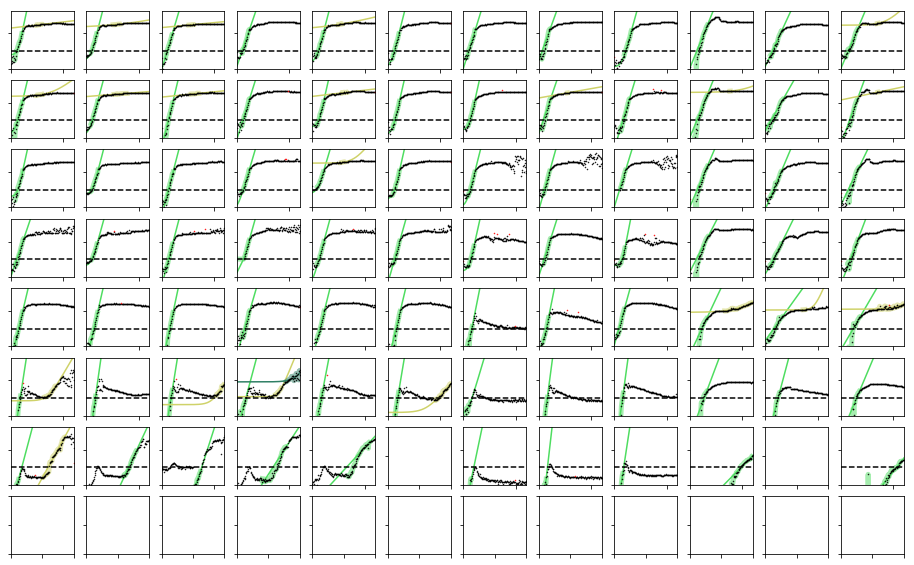

<Figure size 432x288 with 0 Axes>

In [307]:
output_test1_181220 = growth_curve_analysis_all_at_once(
    infile='181220_aztMIC.xlsx', 
    od_cutoff=0.01, 
    blank='H', 
    verbose=True,
    my_xlim=[0,24],
    my_ylim=[0.001,2],
    od_output_time=12)

A1 : 1 growth phases found, rate=(1.45), lag=(1.52), rate* = 1.45, lag* = 1.52
B1 : 1 growth phases found, rate=(1.37), lag=(1.52), rate* = 1.37, lag* = 1.52
C1 : 2 growth phases found, rate=(1.42,0.37), lag=(1.52,21.77), rate* = 1.42, lag* = 1.52
D1 : 1 growth phases found, rate=(1.50), lag=(1.52), rate* = 1.50, lag* = 1.52
E1 : 1 growth phases found, rate=(1.50), lag=(1.69), rate* = 1.50, lag* = 1.69
F1 : 2 growth phases found, rate=(2.08,1.42), lag=(1.19,15.63), rate* = 2.08, lag* = 1.19
G1 : 1 growth phases found, rate=(0.40), lag=(15.26), rate* = 0.40, lag* = 15.26
H1 : data is empty.
A2 : 1 growth phases found, rate=(1.33), lag=(1.35), rate* = 1.33, lag* = 1.35
B2 : 1 growth phases found, rate=(1.27), lag=(1.52), rate* = 1.27, lag* = 1.52
C2 : 1 growth phases found, rate=(1.50), lag=(1.52), rate* = 1.50, lag* = 1.52
D2 : 1 growth phases found, rate=(1.30), lag=(1.52), rate* = 1.30, lag* = 1.52
E2 : 1 growth phases found, rate=(1.50), lag=(1.69), rate* = 1.50, lag* = 1.69
F2 : 2 g

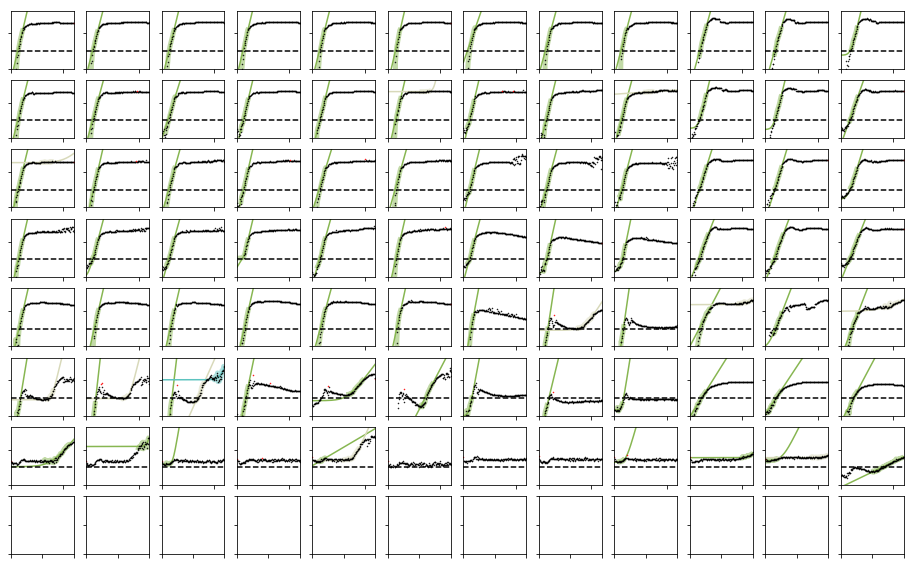

<Figure size 432x288 with 0 Axes>

In [308]:
output_test1_181221 = growth_curve_analysis_all_at_once(
    infile='181221_aztMIC.xlsx', 
    od_cutoff=0.01, 
    blank='H', 
    verbose=True,
    my_xlim=[0,24],
    my_ylim=[0.001,2],
    od_output_time=12)

In [315]:
# calculate mean and standard deviation of growth rate
pd.set_option('precision', 3)
df_GR = pd.DataFrame(index=['NalD.0','NalD.1','NalD.2','PA14.0','PA14.1','PA14.2'],
                  columns=['R1','R2','R3','R4','R5','R6','R7','R8','R9','Mean','Std'])

# NalD + 0 azt
df_GR.loc['NalD.0',['R1','R2','R3']] = output_test1_181219.loc[['A1','A2','A3'],'growth_rate_star'].values
df_GR.loc['NalD.0',['R4','R5','R6']] = output_test1_181220.loc[['A1','A2','A3'],'growth_rate_star'].values
df_GR.loc['NalD.0',['R7','R8','R9']] = output_test1_181221.loc[['A1','A2','A3'],'growth_rate_star'].values

# NalD + 1 azt
df_GR.loc['NalD.1',['R1','R2','R3']] = output_test1_181219.loc[['C1','C2','C3'],'growth_rate_star'].values
df_GR.loc['NalD.1',['R4','R5','R6']] = output_test1_181220.loc[['C1','C2','C3'],'growth_rate_star'].values
df_GR.loc['NalD.1',['R7','R8','R9']] = output_test1_181221.loc[['C1','C2','C3'],'growth_rate_star'].values

# NalD + 2 azt
df_GR.loc['NalD.2',['R1','R2','R3']] = output_test1_181219.loc[['D1','D2','D3'],'growth_rate_star'].values
df_GR.loc['NalD.2',['R4','R5','R6']] = output_test1_181220.loc[['D1','D2','D3'],'growth_rate_star'].values
df_GR.loc['NalD.2',['R7','R8','R9']] = output_test1_181221.loc[['D1','D2','D3'],'growth_rate_star'].values

# PA14 + 0 azt
df_GR.loc['PA14.0',['R1','R2','R3']] = output_test1_181219.loc[['A7','A8','A9'],'growth_rate_star'].values
df_GR.loc['PA14.0',['R4','R5','R6']] = output_test1_181220.loc[['A7','A8','A9'],'growth_rate_star'].values
df_GR.loc['PA14.0',['R7','R8','R9']] = output_test1_181221.loc[['A7','A8','A9'],'growth_rate_star'].values

# PA14 + 1 azt
df_GR.loc['PA14.1',['R1','R2','R3']] = output_test1_181219.loc[['C7','C8','C9'],'growth_rate_star'].values
df_GR.loc['PA14.1',['R4','R5','R6']] = output_test1_181220.loc[['C7','C8','C9'],'growth_rate_star'].values
df_GR.loc['PA14.1',['R7','R8','R9']] = output_test1_181221.loc[['C7','C8','C9'],'growth_rate_star'].values

# PA14 + 2 azt
df_GR.loc['PA14.2',['R1','R2','R3']] = output_test1_181219.loc[['D7','D8','D9'],'growth_rate_star'].values
df_GR.loc['PA14.2',['R4','R5','R6']] = output_test1_181220.loc[['D7','D8','D9'],'growth_rate_star'].values
df_GR.loc['PA14.2',['R7','R8','R9']] = output_test1_181221.loc[['D7','D8','D9'],'growth_rate_star'].values

# Mean and standard deviation
mean = df_GR.mean(axis=1)
std  = df_GR.std(axis=1)
df_GR['Mean'] = mean
df_GR['Std']  = std

# reorganize
df_GR

,R1,R2,R3,R4,R5,R6,R7,R8,R9,Mean,Std
NalD.0,1.03,1.11,1.49,1.61,1.33,1.16,1.45,1.33,1.42,1.325,0.193
NalD.1,1.04,1.01,1.04,1.58,1.34,1.32,1.42,1.5,1.23,1.274,0.211
NalD.2,1.12,0.961,1.08,1.01,1.26,1.32,1.5,1.3,1.24,1.200,0.171
PA14.0,1.32,1.46,1.14,1.11,0.948,1.24,0.992,1.27,1.29,1.199,0.165
PA14.1,1.06,1.04,0.917,1.37,1.23,1.12,1.41,1.29,1.29,1.192,0.166
PA14.2,1.01,1.95,1.42,1.55,1.08,1.78,1.29,1.56,1.68,1.481,0.313


In [316]:
# calculate mean and standard deviation of growth rate
pd.set_option('precision', 3)
df_OD = pd.DataFrame(index=['NalD.0','NalD.1','NalD.2','PA14.0','PA14.1','PA14.2'],
                  columns=['R1','R2','R3','R4','R5','R6','R7','R8','R9','Mean','Std'])

# NalD + 0 azt
df_OD.loc['NalD.0',['R1','R2','R3']] = output_test1_181219.loc[['A1','A2','A3'],'od_output_time'].values
df_OD.loc['NalD.0',['R4','R5','R6']] = output_test1_181220.loc[['A1','A2','A3'],'od_output_time'].values
df_OD.loc['NalD.0',['R7','R8','R9']] = output_test1_181221.loc[['A1','A2','A3'],'od_output_time'].values

# NalD + 1 azt
df_OD.loc['NalD.1',['R1','R2','R3']] = output_test1_181219.loc[['C1','C2','C3'],'od_output_time'].values
df_OD.loc['NalD.1',['R4','R5','R6']] = output_test1_181220.loc[['C1','C2','C3'],'od_output_time'].values
df_OD.loc['NalD.1',['R7','R8','R9']] = output_test1_181221.loc[['C1','C2','C3'],'od_output_time'].values

# NalD + 2 azt
df_OD.loc['NalD.2',['R1','R2','R3']] = output_test1_181219.loc[['D1','D2','D3'],'od_output_time'].values
df_OD.loc['NalD.2',['R4','R5','R6']] = output_test1_181220.loc[['D1','D2','D3'],'od_output_time'].values
df_OD.loc['NalD.2',['R7','R8','R9']] = output_test1_181221.loc[['D1','D2','D3'],'od_output_time'].values

# PA14 + 0 azt
df_OD.loc['PA14.0',['R1','R2','R3']] = output_test1_181219.loc[['A7','A8','A9'],'od_output_time'].values
df_OD.loc['PA14.0',['R4','R5','R6']] = output_test1_181220.loc[['A7','A8','A9'],'od_output_time'].values
df_OD.loc['PA14.0',['R7','R8','R9']] = output_test1_181221.loc[['A7','A8','A9'],'od_output_time'].values

# PA14 + 1 azt
df_OD.loc['PA14.1',['R1','R2','R3']] = output_test1_181219.loc[['C7','C8','C9'],'od_output_time'].values
df_OD.loc['PA14.1',['R4','R5','R6']] = output_test1_181220.loc[['C7','C8','C9'],'od_output_time'].values
df_OD.loc['PA14.1',['R7','R8','R9']] = output_test1_181221.loc[['C7','C8','C9'],'od_output_time'].values

# PA14 + 2 azt
df_OD.loc['PA14.2',['R1','R2','R3']] = output_test1_181219.loc[['D7','D8','D9'],'od_output_time'].values
df_OD.loc['PA14.2',['R4','R5','R6']] = output_test1_181220.loc[['D7','D8','D9'],'od_output_time'].values
df_OD.loc['PA14.2',['R7','R8','R9']] = output_test1_181221.loc[['D7','D8','D9'],'od_output_time'].values

# Mean and standard deviation
mean = df_OD.mean(axis=1)
std  = df_OD.std(axis=1)
df_OD['Mean'] = mean
df_OD['Std']  = std
df_OD

,R1,R2,R3,R4,R5,R6,R7,R8,R9,Mean,Std
NalD.0,0.32328547072154407,0.36005230623436724,0.3686436128893041,0.3341430399114135,0.3367001104202352,0.3254722738795854,0.3842814202674633,0.40962972051251356,0.41737188625313204,0.362,0.036
NalD.1,0.3171889451882384,0.332611427688849,0.32395751418159624,0.30578584679061316,0.31017181428804036,0.3214292253590772,0.37146577723886515,0.36573608085914,0.3718485494261593,0.336,0.027
NalD.2,0.3431555384066043,0.3592088216050403,0.3794044726100455,0.30721287874510117,0.2892004575800931,0.30240172574475926,0.4111262314361364,0.40252070478224744,0.40822360913081,0.356,0.048
PA14.0,0.3652075770191281,0.41926396908507413,0.401341867674719,0.3850005645172331,0.42538640606700545,0.3512998980436244,0.4286018667248838,0.41890158499481056,0.4221519801601905,0.402,0.028
PA14.1,0.29522323378378873,0.3206627216835426,0.3114115435610528,0.3708730733429328,0.3781005647904134,0.3841420004377409,0.3927217455546609,0.3685734656228735,0.3510594108689508,0.353,0.035
PA14.2,0.24186682484780006,0.051563347653141176,0.08745813428416965,0.1568318662185229,0.2872710008176014,0.09657284002998572,0.3442888527453493,0.15326100656166283,0.17387344722032289,0.177,0.097


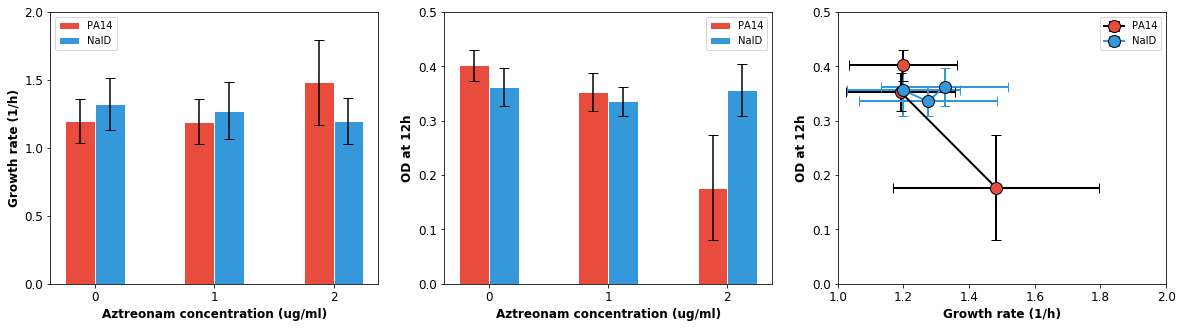

In [320]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1]},figsize=(20,5))

#==============
# growth rate
#==============

#set width of bar
barWidth = 0.25

# set height of bar
barm1GR = df_GR.loc[['PA14.0','PA14.1','PA14.2'],'Mean'].values
bars1GR = df_GR.loc[['PA14.0','PA14.1','PA14.2'],'Std'].values
barm2GR = df_GR.loc[['NalD.0','NalD.1','NalD.2'],'Mean'].values
bars2GR = df_GR.loc[['NalD.0','NalD.1','NalD.2'],'Std'].values

# Set position of bar on X axis
r1 = np.arange(len(barm1GR))
r2 = [x + barWidth for x in r1]
 
# Make the plot
ax1.bar(r1, barm1GR, yerr=bars1GR, capsize=5, color='#e74c3c', width=barWidth, edgecolor='white', label='PA14')
ax1.bar(r2, barm2GR, yerr=bars2GR, capsize=5, color='#3498db', width=barWidth, edgecolor='white', label='NalD')
 
# Add xticks on the middle of the group bars
ax1.set_xlabel('Aztreonam concentration (ug/ml)', fontweight='bold', fontsize=12)
ax1.set_xticks([r + barWidth/2 for r in range(len(barm1GR))])
ax1.set_xticklabels(['0', '1', '2'])
ax1.set_ylabel('Growth rate (1/h)', fontweight='bold', fontsize=12)
ax1.set_ylim([0,2])
ax1.set_yticks([0,0.5,1.0,1.5,2.0])
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
ax1.legend(loc = 'upper left')

#==============
# OD at 12 h
#==============

#set width of bar
barWidth = 0.25

# set height of bar
barm1OD = df_OD.loc[['PA14.0','PA14.1','PA14.2'],'Mean'].values
bars1OD = df_OD.loc[['PA14.0','PA14.1','PA14.2'],'Std'].values
barm2OD = df_OD.loc[['NalD.0','NalD.1','NalD.2'],'Mean'].values
bars2OD = df_OD.loc[['NalD.0','NalD.1','NalD.2'],'Std'].values

# Set position of bar on X axis
r1 = np.arange(len(barm1OD))
r2 = [x + barWidth for x in r1]
 
# Make the plot
ax2.bar(r1, barm1OD, yerr=bars1OD, capsize=5, color='#e74c3c', width=barWidth, edgecolor='white', label='PA14')
ax2.bar(r2, barm2OD, yerr=bars2OD, capsize=5, color='#3498db', width=barWidth, edgecolor='white', label='NalD')
 
# Add xticks on the middle of the group bars
ax2.set_xlabel('Aztreonam concentration (ug/ml)', fontweight='bold', fontsize=12)
ax2.set_xticks([r + barWidth/2 for r in range(len(barm1OD))])
ax2.set_xticklabels(['0', '1', '2'])
ax2.set_ylabel('OD at 12h', fontweight='bold', fontsize=12)
ax2.set_ylim([0,0.5])
ax2.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax2.tick_params(axis="x", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
ax2.legend(loc = 'upper right')

#====================
# rate-yield tradeoff
#====================
ax3.errorbar(barm1GR, barm1OD, xerr=bars1GR, yerr=bars1OD, marker='o', markeredgecolor='k', 
             markerfacecolor='#e74c3c', markersize=12, color='k', linewidth=2, capsize=5, label='PA14')
ax3.errorbar(barm2GR, barm2OD, xerr=bars2GR, yerr=bars2OD, marker='o', markeredgecolor='k', 
             markerfacecolor='#3498db', markersize=12, color='#3498db', linewidth=2, capsize=5, label='NalD')
ax3.set_xlabel('Aztreonam concentration (ug/ml)', fontweight='bold', fontsize=12)
ax3.set_xlim([1,2])
ax3.set_ylim([0,0.5])
ax3.set_xlabel('Growth rate (1/h)', fontweight='bold', fontsize=12)
ax3.set_ylabel('OD at 12h', fontweight='bold', fontsize=12)
ax3.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax3.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax3.tick_params(axis="x", labelsize=12)
ax3.tick_params(axis="y", labelsize=12)
ax3.legend(loc = 'upper right')

plt.show()

# Run test 2: growth curve analysis of PA14 in glycerol minimum media

A1 : data is empty.
B1 : data is empty.
C1 : data is empty.
D1 : data is empty.
E1 : data is empty.
F1 : data is empty.
G1 : data is empty.
H1 : data is empty.
A2 : 2 growth phases found, rate=(0.30,0.02), lag=(17.06,32.68), rate* = 0.30, lag* = 17.06
B2 : 2 growth phases found, rate=(0.31,0.03), lag=(17.17,32.52), rate* = 0.31, lag* = 17.17
C2 : 2 growth phases found, rate=(0.30,0.03), lag=(17.21,32.52), rate* = 0.30, lag* = 17.21
D2 : 2 growth phases found, rate=(0.32,0.07), lag=(16.89,39.17), rate* = 0.32, lag* = 16.89
E2 : 2 growth phases found, rate=(0.28,0.03), lag=(17.55,32.18), rate* = 0.28, lag* = 17.55
F2 : 2 growth phases found, rate=(0.30,0.09), lag=(17.16,40.89), rate* = 0.30, lag* = 17.16
G2 : 2 growth phases found, rate=(0.28,0.03), lag=(16.66,29.97), rate* = 0.28, lag* = 16.66
H2 : 2 growth phases found, rate=(0.26,0.01), lag=(17.57,33.36), rate* = 0.26, lag* = 17.57
A3 : 1 growth phases found, rate=(0.42), lag=(22.48), rate* = 0.42, lag* = 22.48
B3 : 2 growth phases fo

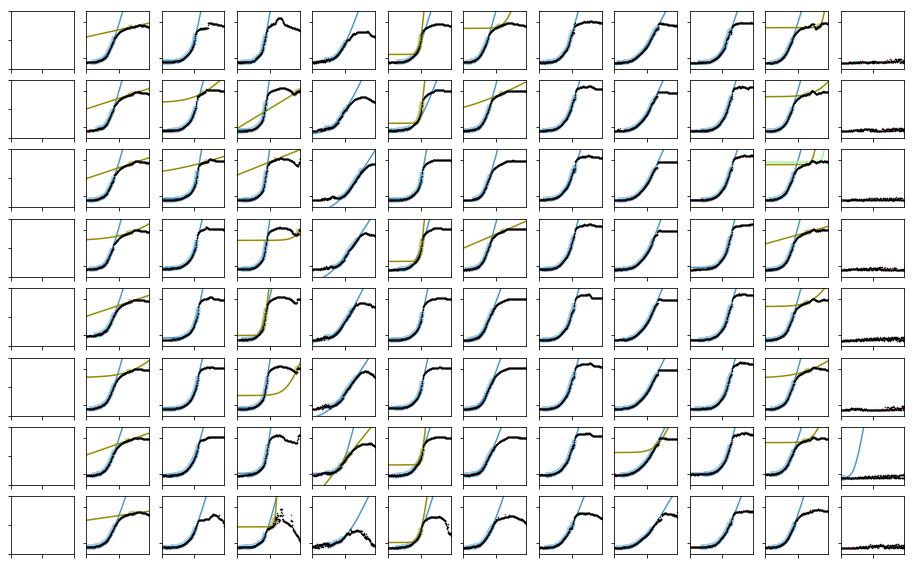

<Figure size 432x288 with 0 Axes>

In [306]:
output_test2 = growth_curve_analysis_all_at_once(
    infile='181109_glycerol_clinical.xlsx', 
    od_cutoff=0.01, 
    blank='1', 
    verbose=True,
    my_xlim=[0,48],
    my_ylim=[0.05,2])

In [256]:
output_test2.head()

,end_time1,end_time2,end_time3,final_od,growth_rate1,growth_rate2,growth_rate3,growth_rate_star,init_od,lag_time1,lag_time2,lag_time3,lag_time_star,max_od,od_output_time,start_time1,start_time2,start_time3
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


E4 : 2 growth phases found, rate=(0.40,0.73), lag=(18.39,20.30), rate* = 0.73, lag* = 20.30


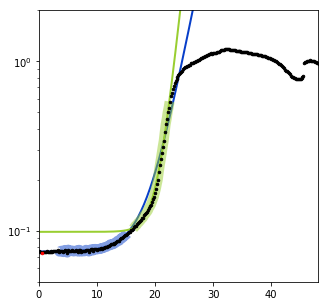

<Figure size 432x288 with 0 Axes>

In [281]:
# analyze E4
growth_curve_analysis_single_curve(
    infile='181109_glycerol_clinical.xlsx', 
    my_col='E4',
    od_cutoff=0.01, 
    blank='1', 
    verbose=True,
    my_xlim=[0,48],
    my_ylim=[0.05,2])

D6 : 2 growth phases found, rate=(0.31,0.90), lag=(21.70,24.96), rate* = 0.90, lag* = 24.96


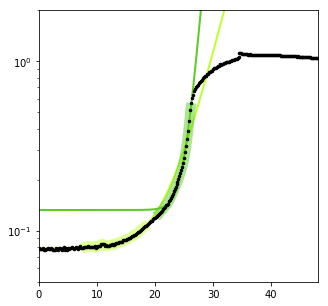

<Figure size 432x288 with 0 Axes>

In [282]:
# analyze D6
growth_curve_analysis_single_curve(
    infile='181109_glycerol_clinical.xlsx', 
    my_col='D6',
    od_cutoff=0.01, 
    blank='1', 
    verbose=True,
    my_xlim=[0,48],
    my_ylim=[0.05,2])

0.13 <= growth rate (1/h) <= 0.90
12.98 <= lag time (h) <= 26.21


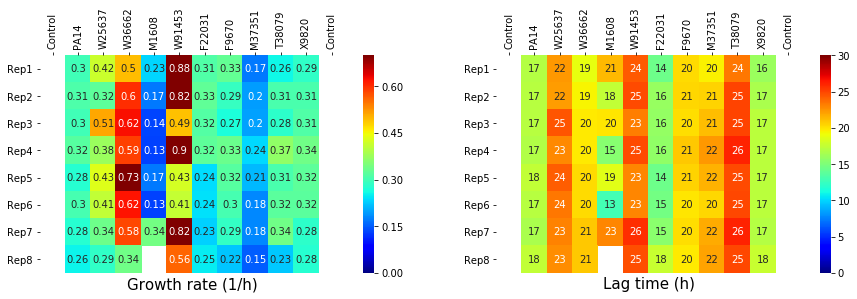

In [260]:
# visualize growth rate and lag time
print('%2.2f <= growth rate (1/h) <= %2.2f' %(np.nanmin(output_test2['growth_rate_star'].values), 
                                              np.nanmax(output_test2['growth_rate_star'].values)))
print('%2.2f <= lag time (h) <= %2.2f'  %(np.nanmin(output_test2['lag_time_star'].values), 
                                          np.nanmax(output_test2['lag_time_star'].values)))

fig,(ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios':[1,1]},figsize=(15,4))

# growth rate
to_plot1 = pd.DataFrame(output_test2['growth_rate_star'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='jet', vmin=0, vmax=0.7, ax=ax1, cbar=True)
ax1.set_xlabel('Growth rate (1/h)', fontsize=15)

# lag time
to_plot2 = pd.DataFrame(output_test2['lag_time_star'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax2, cbar=True)
ax2.set_xlabel('Lag time (h)', fontsize=15)

for ax in [g1,g2]:
    ax.set_yticklabels(['Rep1','Rep2','Rep3','Rep4','Rep5','Rep6','Rep7','Rep8'], rotation=0)
    ax.set_xticklabels(['Control','PA14','W25637','W36662','M1608','W91453','F22031','F9670','M37351','T38079','X9820','Control'], rotation=90)
    ax.xaxis.tick_top()

plt.show()

# Run test 3: growth curve analysis of PA14 in arginine medium

A1 : 1 growth phases found, rate=(1.35), lag=(3.22), rate* = 1.35, lag* = 3.22
B1 : 1 growth phases found, rate=(1.67), lag=(1.52), rate* = 1.67, lag* = 1.52
C1 : 1 growth phases found, rate=(1.01), lag=(2.37), rate* = 1.01, lag* = 2.37
D1 : 1 growth phases found, rate=(1.12), lag=(2.71), rate* = 1.12, lag* = 2.71
E1 : 2 growth phases found, rate=(0.40,0.19), lag=(1.69,32.16), rate* = 0.40, lag* = 1.69
F1 : 1 growth phases found, rate=(0.42), lag=(2.20), rate* = 0.42, lag* = 2.20
G1 : 1 growth phases found, rate=(0.39), lag=(6.05), rate* = 0.39, lag* = 6.05
H1 : 1 growth phases found, rate=(0.45), lag=(4.06), rate* = 0.45, lag* = 4.06
A2 : 1 growth phases found, rate=(0.13), lag=(44.16), rate* = 0.13, lag* = 44.16
B2 : no growth phase is found.
C2 : 1 growth phases found, rate=(0.30), lag=(4.57), rate* = 0.30, lag* = 4.57
D2 : 1 growth phases found, rate=(0.11), lag=(1.86), rate* = 0.11, lag* = 1.86
E2 : 1 growth phases found, rate=(0.12), lag=(7.11), rate* = 0.12, lag* = 7.11
F2 : 1 g

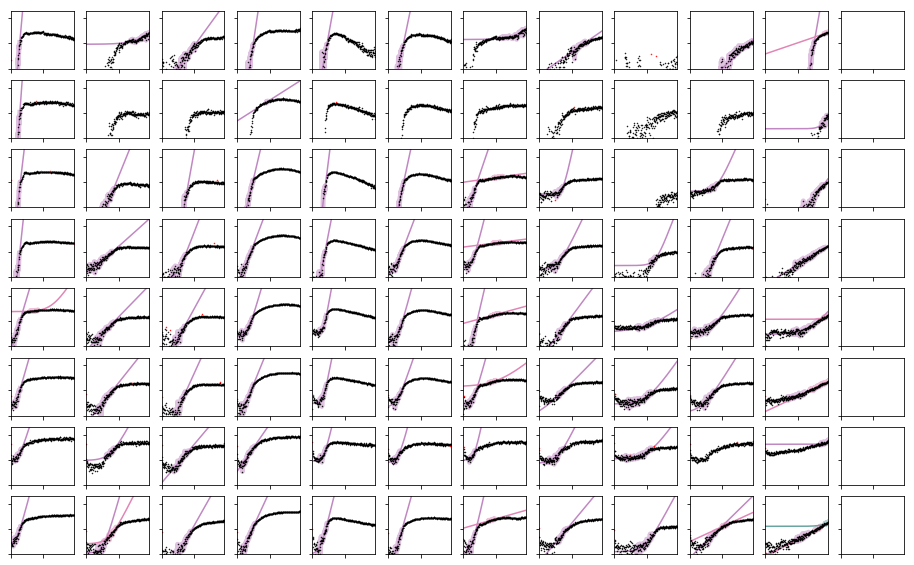

<Figure size 432x288 with 0 Axes>

In [261]:
# od no cutoff
output_test3_nocutoff = growth_curve_analysis_all_at_once(
    infile='190707_Arg.xlsx',
    od_cutoff=None, 
    blank='12',
    verbose=True,
    my_xlim=[0,48],
    my_ylim=[0.001,0.2])

A1 : 1 growth phases found, rate=(1.35), lag=(3.22), rate* = 1.35, lag* = 3.22
B1 : 1 growth phases found, rate=(1.67), lag=(1.52), rate* = 1.67, lag* = 1.52
C1 : 1 growth phases found, rate=(1.01), lag=(2.37), rate* = 1.01, lag* = 2.37
D1 : 1 growth phases found, rate=(1.12), lag=(2.71), rate* = 1.12, lag* = 2.71
E1 : 2 growth phases found, rate=(0.45,0.18), lag=(1.52,32.53), rate* = 0.45, lag* = 1.52
F1 : 1 growth phases found, rate=(0.39), lag=(1.86), rate* = 0.39, lag* = 1.86
G1 : 1 growth phases found, rate=(0.39), lag=(6.05), rate* = 0.39, lag* = 6.05
H1 : 1 growth phases found, rate=(0.42), lag=(3.49), rate* = 0.42, lag* = 3.49
A2 : 1 growth phases found, rate=(0.13), lag=(44.16), rate* = 0.13, lag* = 44.16
B2 : no growth phase is found.
C2 : 1 growth phases found, rate=(0.30), lag=(4.57), rate* = 0.30, lag* = 4.57
D2 : 1 growth phases found, rate=(0.13), lag=(3.45), rate* = 0.13, lag* = 3.45
E2 : 1 growth phases found, rate=(0.27), lag=(19.58), rate* = 0.27, lag* = 19.58
F2 : 1

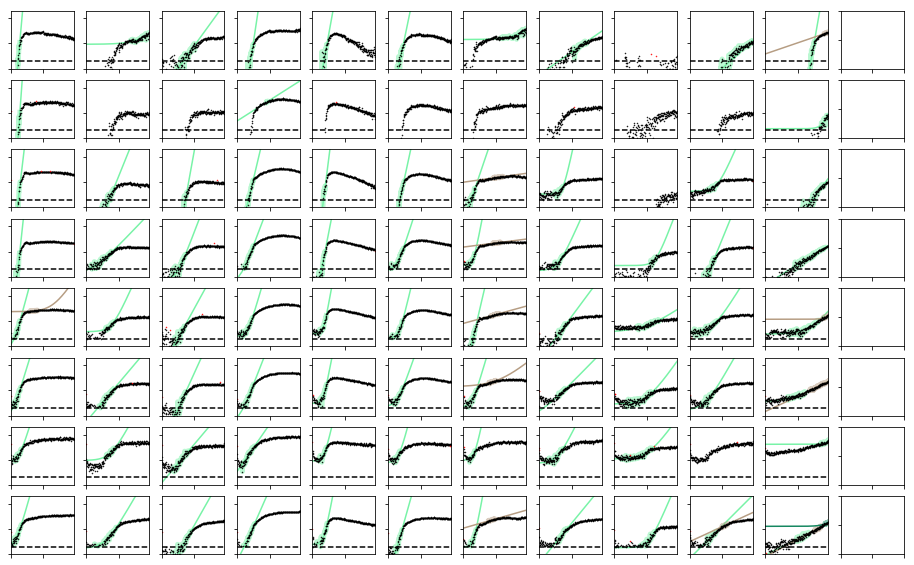

<Figure size 432x288 with 0 Axes>

In [294]:
# od cutoff 0.001
output_test3_wcutoff = growth_curve_analysis_all_at_once(
    infile='190707_Arg.xlsx',
    od_cutoff=0.002, 
    blank='12',
    verbose=True,
    my_xlim=[0,48],
    my_ylim=[0.001,0.2])

E2 : 1 growth phases found, rate=(0.12), lag=(7.11), rate* = 0.12, lag* = 7.11


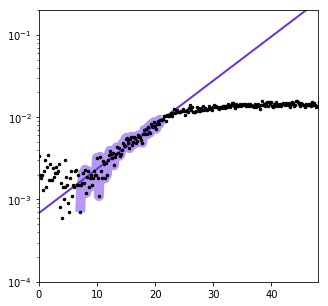

E2 : 1 growth phases found, rate=(0.27), lag=(19.58), rate* = 0.27, lag* = 19.58


<Figure size 432x288 with 0 Axes>

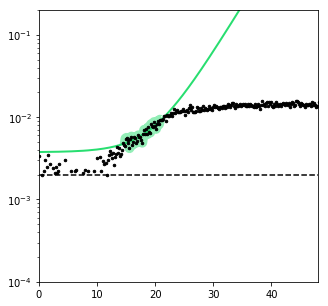

<Figure size 432x288 with 0 Axes>

In [321]:
# cutoff sometimes lead to error. take E2 as an example

growth_curve_analysis_single_curve(
    infile='190707_Arg.xlsx',
    my_col = 'E2',
    od_cutoff=None, 
    blank='12',
    verbose=True,
    my_xlim=[0,48],
    my_ylim=[0.0001,0.2])

growth_curve_analysis_single_curve(
    infile='190707_Arg.xlsx',
    my_col = 'E2',
    od_cutoff=0.002, 
    blank='12',
    verbose=True,
    my_xlim=[0,48],
    my_ylim=[0.0001,0.2])

0.06 <= growth rate (1/h) <= 2.01
1.35 <= lag time (h) <= 45.07


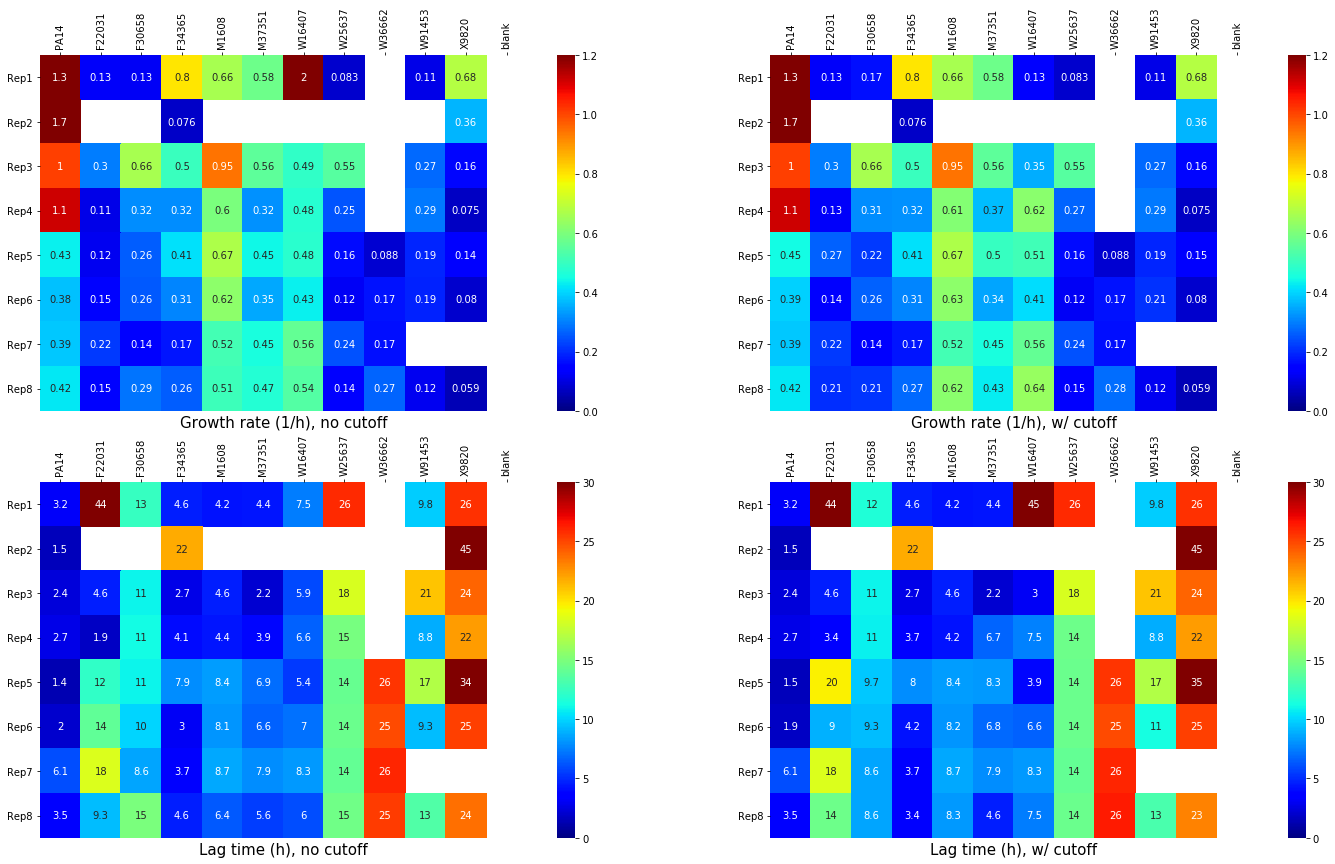

In [305]:
# visualize growth rate and lag time
print('%2.2f <= growth rate (1/h) <= %2.2f' %(np.nanmin(output_test3_nocutoff['growth_rate_star'].values), 
                                              np.nanmax(output_test3_nocutoff['growth_rate_star'].values)))
print('%2.2f <= lag time (h) <= %2.2f'  %(np.nanmin(output_test3_nocutoff['lag_time_star'].values), 
                                          np.nanmax(output_test3_nocutoff['lag_time_star'].values)))

fig,ax = plt.subplots(2,2,figsize=(24,14.4))

# growth rate
to_plot1 = pd.DataFrame(output_test3_nocutoff['growth_rate_star'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='jet', vmin=0, vmax=1.2, ax=ax[0,0], cbar=True)
ax[0,0].set_xlabel('Growth rate (1/h), no cutoff', fontsize=15)

to_plot3 = pd.DataFrame(output_test3_wcutoff['growth_rate_star'].values.reshape(8,12,order='F'))
g3 = sns.heatmap(to_plot3, robust=True, annot=True, cmap='jet', vmin=0, vmax=1.2, ax=ax[0,1], cbar=True)
ax[0,1].set_xlabel('Growth rate (1/h), w/ cutoff', fontsize=15)

# lag time
to_plot2 = pd.DataFrame(output_test3_nocutoff['lag_time_star'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax[1,0], cbar=True)
ax[1,0].set_xlabel('Lag time (h), no cutoff', fontsize=15)

to_plot4 = pd.DataFrame(output_test3_wcutoff['lag_time_star'].values.reshape(8,12,order='F'))
g4 = sns.heatmap(to_plot4, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax[1,1], cbar=True)
ax[1,1].set_xlabel('Lag time (h), w/ cutoff', fontsize=15)

for ax in [g1,g2,g3,g4]:
    ax.set_yticklabels(['Rep1','Rep2','Rep3','Rep4','Rep5','Rep6','Rep7','Rep8'], rotation=0)
    ax.set_xticklabels(["PA14","F22031","F30658","F34365","M1608","M37351","W16407","W25637","W36662","W91453","X9820","blank"], rotation=90)
    ax.xaxis.tick_top()

plt.show()